In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

In [2]:
class Lake():

    def __init__(self, L, noise_level=1, wind_level=0.01, stepsize = 0.01):
        self.L = L
        self.noise_level = noise_level
        self.wind_level = wind_level
        self.stepsize = stepsize
        self.freqs = np.random.randint(1,10,self.noise_level) * np.pi / self.L
        self.amps = np.random.rand(self.noise_level) * self.wind_level
        self.x = np.arange(0, self.L+stepsize, stepsize)
    
    def profile(self, x):
        return jnp.sum(jnp.array([amp * jnp.sin(freq * x) for freq, amp in zip(self.freqs, self.amps)]))

    def vprofile(self, x):
        return jax.vmap(self.profile)(x)

    def slope(self, x):
        return jax.grad(self.profile)(x)
        

In [32]:
class Source():

    def __init__(self, x0, height, size, brightness_type='uniform'):
        self.x0 = x0
        self.height = height
        self.size = size
        self.brightness_type = brightness_type
        self.y = np.arange(0, self.height + 2 * self.height, 0.01)

    def brightness(self, y):
        if self.brightness_type == 'uniform':
            if np.abs(y - self.height) < self.size:
                return 1
            else:
                return 0
        elif self.brightness_type == 'gaussian':
            return jnp.exp(-(y-self.height)**2 / self.size**2)

In [18]:
class Ray():

    def __init__(self, x0, y0, slope):
        self.x0 = x0
        self.y0 = y0
        self.slope = slope

    def y(self, x):
        return self.slope * (x - self.x0) + self.y0

    def reflect(self,L):
        for x in np.flip(L.x):
            if self.y(x) < L.profile(x):
                slope_lake = L.slope(x)
                self.x0 = x
                self.y0 = L.profile(x)
                try:
                    self.slope = (-2 * slope_lake + self.slope - slope_lake ** 2 * self.slope) / (-1 + slope_lake ** 2 - 2 * slope_lake * self.slope)
                except ZeroDivisionError:
                    self.slope = self.slope
                break
        
    def brightness(self, S):
        self.brightness = S.brightness(self.y(S.x0))

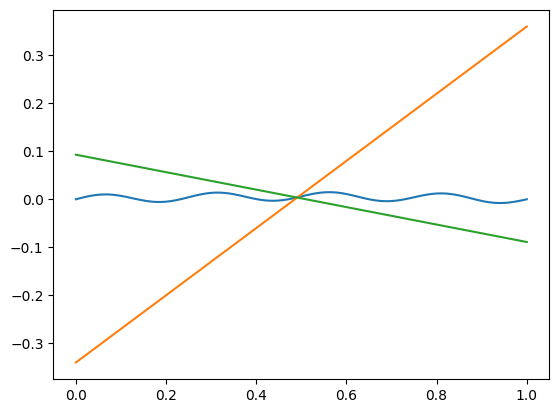

In [21]:
r = Ray(1.2, 0.5, 0.7)
l = Lake(1,2)
s = Source(-0.1, 0.5, 0.1)
plt.plot(l.x, l.vprofile(l.x))
plt.plot(l.x, r.y(l.x))
r.reflect(l)
plt.plot(l.x, r.y(l.x))
plt.show()

In [22]:
class Pixel():

    def __init__(self, x0, y0, size = 0.01):
        self.x0 = x0
        self.y0 = y0
        self.size = size
        self.brightness = 0

    def how_bright(self, L, S):
        for slope in np.arange(np.arctan2(self.y0, self.x0 - L.x[0]), np.arctan2(self.y0, self.x0 - L.x[-1]), L.stepsize):
            ray = Ray(self.x0, self.y0, slope)
            ray.reflect(L)
            ray.brightness(S)
            self.brightness += ray.brightness
        

In [37]:
class Screen():

    def __init__(self, x0, H, pixel=0.01):
        self.H = H
        self.x0 = x0
        self.pixel = pixel
        self.y = np.arange(0, self.H+pixel, pixel)
        self.brightness = []

    def update(self, lake, source):
        print('Updating screen...')
        for y in self.y:
            p = Pixel(self.x0, y, size = self.pixel)
            p.how_bright(lake, source)
            self.brightness.append(p.brightness)
    
    def plot(self, source, lake):
        print('Plotting screen...')
        plt.plot(lake.x, lake.vprofile(lake.x), color = 'cornflowerblue')
        max_brightness_source = np.max(source.brightness(source.y))
        max_brightness = np.max(self.brightness)
        [plt.plot(source.x0, source.y[i], 'x', color = 'red', alpha = float(source.brightness(source.y[i]) / max_brightness_source)) for i in range(len(source.y))]
        [plt.plot(self.x0, self.y[i], 'x', color = 'orange', alpha = float(self.brightness[i] / max_brightness)) for i in range(len(self.y))]
        plt.show() 

Updating screen...
Plotting screen...


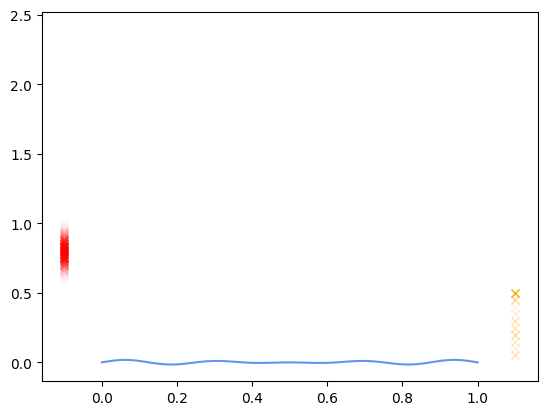

In [38]:
l = Lake(1, 3)
s = Source(-0.1,0.8, 0.1, brightness_type='gaussian')
C = Screen(1.1, 0.5, pixel=0.05)
C.update(l, s)
C.plot(s, l)